# Comparison Experiments for Auto-Adjustable and Time-Consistent Model (AATC-LSTM) vs 13 Baseline Models for Water Treatment 


## Training + Validating All Models, and Predicting for Shanghai SMI Dataset

In [1]:
import torch
import numpy as np
import torch.nn as nn 
from DataSet import DataSet

# Deep + ANFIS
from models import AALSTM
from models import LSTM
from models import TCN
from models import ANFIS

import config
import os.path as osp
import pandas as pd
import xlrd
import os
import math
import logging
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLars
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
import datetime
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, CuDNNLSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/yqliu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yqliu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_c

In [2]:
class Water:
    def __init__(self, excel_files):
        self.source = DataSet(excel_files)
        
    """ ***************Structure All Model Instances***************"""
    def build_model(self, method, source):
        
        if method== 'AATC-LSTM':            
            valX = source.dagger_x_test
            valY = source.dagger_y_test           
            val_dagger_save_metric = []
            aatc_metric = np.zeros([4])
            self.bestScore_dagger = 1000          
            self.in_features = valX.size(2)
            self.epoch = 30
            self.batchSize_train = 128
            self.batchSize_val = 16
            self.trainSeq =  self.seq_abrupt = source.deep_dagger_x.size(1)
            self.testSeq = valX.size(1)
            
            # save path
            self.Ctime = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
            
            mse_criterion = nn.MSELoss()

            lambda1 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda2 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda3 = [1e-3, 1e-2, 1e-1, 8e-1, 0, 1, 1e1]
            
            aalstm = AALSTM(self.in_features, self.trainSeq, self.testSeq).cuda().double()
            optimizer_dagger = torch.optim.Adam(aalstm.parameters(), lr = 1e-2)
            
    
            loss_aatc_save = []
            loss_dag_sum = 0
            count_dag = 0
            
            for i in range(self.epoch):
                
                be_idx = 0
                
                if i==0:
                    trainX_dag = source.deep_dagger_x
                    trainY_dag = source.deep_dagger_y
                else:
                    trainX_dag = source.dagger_shuffle[:,:,:-1]
                    trainY_dag = source.dagger_shuffle[:,:,-1]
                
                while(be_idx + self.batchSize_train) <= (trainX_dag.size(0) - 1):
                    optimizer_dagger.zero_grad()
                    
                    dag_params1 = aalstm.parameters()
                    L1_dag_sum = self.sum_params4L(dag_params1, 'L1')
                    
                    dag_params2 = aalstm.parameters()
                    L2_dag_sum = self.sum_params4L(dag_params2, 'L2')
                
                    ed_idx = be_idx + self.batchSize_train
                    
                    # calculating number of turbidity (turbidity rate)
                    AD_rate = cal_AC(trainX[batch_bidx:(batch_eidx + 1),:,:], self.batch_size_train, self.seq_train, 'batch')                    
       
                    out = aalstm(trainX_dag[be_idx:ed_idx,:,:], trainY_dag[be_idx:ed_idx,:], True)

                    # Total Loss (TC Term)
                    loss_dag = AD_rate * mse_criterion(out, trainY_dag[be_idx:ed_idx,:]) + lambda1[1] * L1_dag_sum \
                    + lambda2[2] * L2_dag_sum
                              
                    loss_dag.backward()
                    optimizer_dagger.step()
                    loss_dag_sum = loss_dag + loss_dag_sum                    
                    be_idx = ed_idx
                    count_dag = count_dag + 1
                    
                average_dag_loss = loss_dag_sum / count_dag
                epoch_num = 'epoch' + str(i)
                # saving training loss
                loss_aatc_save.append(average_dag_loss)
                    
                loss_dag_sum = 0
                count_dag = 0
                

                
                ## validation
                if i>=5 and i%5==0:
                    
                    batch_dag_val_b = 0
                    rmse_dag_score_total = 0
                    mape_dag_score_total = 0
                    corr_dag_score_total = 0
                    wi_dag_score_total = 0
                    count_dag_val = 0
                    
                    val_oneBatch_dagger_metric = np.zeros([4])
                    
                    while (batch_dag_val_b + self.batchSize_val) <= valX.size(0):
                        with torch.no_grad():
                            batch_dag_val_e = batch_dag_val_b + self.batchSize_val
                            valXSlice = valX[batch_dag_val_b:batch_dag_val_e,:,:]
                            valYSlice = valY[batch_dag_val_b:batch_dag_val_e]
                            
                            val_dag_out = daggertenlar(valXSlice, valYSlice, False)
                            
                            # calculate metrics for deep
                            rmse_dag_score = self.cal_rmse4deep(val_dag_out, valYSlice, 'rmse')
                            mape_dag_score = self.cal_rmse4deep(val_dag_out, valYSlice, 'mape')
                            corr_dag_score = self.cal_rmse4deep(val_dag_out, valYSlice, 'correlation')
                            wi_dag_score = self.cal_rmse4deep(val_dag_out, valYSlice, 'wi')
                            
                            rmse_dag_score_total = rmse_dag_score_total + rmse_dag_score
                            mape_dag_score_total = mape_dag_score_total + mape_dag_score
                            corr_dag_score_total = corr_dag_score_total + corr_dag_score
                            wi_dag_score_total = wi_dag_score_total + wi_dag_score
                            
                            batch_dag_val_b = batch_dag_val_e
                            count_dag_val = count_dag_val + 1
                            
                    #     
                    val_oneBatch_dagger_metric[0] = rmse_dag_av_score = rmse_dag_score_total / count_dag_val
                    val_oneBatch_dagger_metric[1] = mape_dag_av_score = mape_dag_score_total / count_dag_val
                    val_oneBatch_dagger_metric[2] = corr_dag_av_score = corr_dag_score_total / count_dag_val
                    val_oneBatch_dagger_metric[3] = wi_dag_av_score = wi_dag_score_total / count_dag_val                       
                        
#     
                    
                    if rmse_dag_av_score < self.bestScore_dagger:
                        print ('validation_dagger_best_score:', rmse_dag_av_score)
                        print ('current_best_epoch:', i)
                        
                        val_dagger_save_metric.append(val_oneBatch_dagger_metric)
                        
                        #saving
                        best_dagger_model_path = os.path.join("./aatclstm", self.Ctime)                        
                        if not os.path.exists(best_dagger_model_path):
                            os.makedirs(best_dagger_model_path)
                        
                        torch.save(aalstm.state_dict(), os.path.join(best_dagger_model_path, "epoch-{}-dagger-rmseScore-{}.pt".format(i, rmse_dag_av_score)))

                        self.bestScore_dagger = rmse_dag_av_score
            # 
            val_save_metric_dagger = np.concatenate(val_dagger_save_metric)
            val_save_metric_dagger = val_save_metric_dagger.reshape(-1, 4)
            
            for i in range(val_save_metric_dagger.shape[1]):
                val_save_metric_dagger_slice = val_save_metric_dagger[:, i]
                val_save_metric_dagger_slice.sort(0)
                
                if i==0 or i==1:
                    aatc_metric[i] = val_save_metric_dagger_slice[0]
                else:
                    aatc_metric[i] = val_save_metric_dagger_slice[-1]
            
            return aatc_metric
                        
                                                  
        if method=='TC-LSTM':

            validX = source.deep_x_test
            validY = source.deep_y_test
            val_save_metric = []
            tclstm_metric = np.zeros([4])
            self.best_score = 1000
            self.in_channels = validX.size(1)
            self.out_channels = 128
            self.kernel_size = 19
            self.stride = 1
            self.padding = 9
            self.epoch = 50
            self.batch_size_train = 128
            self.batch_size_val = 10
            self.seq_train =  source.deep_x.size(2)
            self.subpath = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
            
            lambda1 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda2 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda3 = [1e-3, 1e-2, 1e-1, 8e-1, 0, 1, 1e1]
            
            mse_criterion = nn.MSELoss()
        
            tclstm = LSTM(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding).cuda().double()
            optimizer = torch.optim.Adam(tclstm.parameters(), lr = 1e-4)
                       
            # init loss variable
            loss_tc_save = []
            loss_sum = 0
            # count clear zero
            count = 0
            
            for i in range(self.epoch): 
            
                """Training:"""
                batch_bidx = 0
                if i==0:
                    trainX = source.deep_x
                    trainY = source.deep_y
                    
                else:
                    total_shuffle = source.rand_total_shuffle
                    channel_size_total = total_shuffle.size(1) - 1
                    trainX = total_shuffle[:,:channel_size_total,:]
                    trainY = total_shuffle[:,-1,:]
   
                while (batch_bidx + self.batch_size_train - 1) <= (trainX.size(0) - 1):
                    optimizer.zero_grad()
                    model_params1 = tclstm.parameters()                    
                    L1_sum = self.sum_params4L(model_params1, 'L1')
                    model_params2 = deeptenlar.parameters()
                    L2_sum = self.sum_params4L(model_params2, 'L2')
                
                    
                    batch_eidx = batch_bidx + self.batch_size_train - 1
                    AC_rate =  cal_AC(trainX[batch_bidx:(batch_eidx + 1),:,:], self.batch_size_train, self.seq_train, 'batch')        
                    out = deeptenlar(trainX[batch_bidx:(batch_eidx + 1),:,:])                              
            
                    # TCLSTM          
                    loss = AC_rate * mse_criterion(out, trainY[batch_bidx:(batch_eidx + 1),:]) + lambda1[2] * L1_sum \
                     + lambda2[2] * L2_sum                 

                    loss.backward()       
                    optimizer.step()
                    loss_sum = loss_sum + loss                    
                    batch_bidx = batch_eidx + 1
                    count = count + 1
                
                average_loss = loss_sum / count
                epoch_num = 'epoch' + str(i)
                loss_tc_save.append(average_loss)
                loss_sum = 0
                count = 0
               
                """Validating (val/2 epochs):"""               
                if i>=5 and i % 5 == 0 :
                    
                    # init basic variable
                    batch_val_b = 0
                    rmse_score_total = 0
                    mape_score_total = 0
                    corr_score_total = 0
                    wi_score_total = 0
                    count = 0
                    
                    # init saved variable
                    val_oneBatch_metric = np.zeros([4])
                    len_validX = len(validX)
                    while ((batch_val_b + self.batch_size_val) <= (len(validX) - 1)):
                        
                        with torch.no_grad():
                            batch_val_e = batch_val_b + self.batch_size_val - 1
                            validXSlice = validX[batch_val_b:(batch_val_e + 1),:,:]
                            validYSlice = validY[batch_val_b:(batch_val_e + 1)]                      
                            val_out = deeptenlar(validXSlice)

                            rmse_score = self.cal_rmse4deep(val_out, validYSlice, 'rmse')
                            mape_score = self.cal_rmse4deep(val_out, validYSlice, 'mape')
                            corr_score = self.cal_rmse4deep(val_out, validYSlice, 'correlation')
                            wi_score = self.cal_rmse4deep(val_out, validYSlice, 'wi')

                            rmse_score_total = rmse_score_total + rmse_score
                            mape_score_total = mape_score_total + mape_score
                            corr_score_total = corr_score_total + corr_score
                            wi_score_total = wi_score_total + wi_score

                            batch_val_b = batch_val_e + 1
                            count = count + 1
                                               
                    val_oneBatch_metric[0] = rmse_av_score = rmse_score_total / count
                    val_oneBatch_metric[1] = mape_av_score = mape_score_total / count
                    val_oneBatch_metric[2] = corr_av_score = corr_score_total / count
                    val_oneBatch_metric[3] = wi_av_score = wi_score_total / count
                      
                        
                    if rmse_av_score < self.best_score:
                        
                        # saving
                        val_save_metric.append(val_oneBatch_metric)
                        best_model_path = os.path.join("./tclstm", self.subpath)
                        
                        if not os.path.exists(best_model_path): 
                            os.makedirs(best_model_path)

                        torch.save(tclstm.state_dict(), os.path.join(best_model_path, "epoch-{}-rmseScore-{}.pt".format(i, rmse_av_score)))
                        self.best_score = rmse_av_score
                        
            val_save_metric_ga = np.concatenate(val_save_metric)
            val_save_metric_ga = val_save_metric_ga.reshape(-1,4)
                    
            # sorting
            for i in range(val_save_metric_ga.shape[1]):
                val_save_metric_ga_slice = val_save_metric_ga[:, i]
                val_save_metric_ga_slice.sort(0)
                
                if i == 0 or i == 1:
                    tclstm_metric[i] = val_save_metric_ga_slice[0] 
                              
                else:
                    tclstm_metric[i] = val_save_metric_ga_slice[-1]
                                                                    
            return tclstm_metric
        
        if method=='TC-TCN':
            
            valX = source.dagger_x_test
            valY = source.dagger_y_test
            
            val_tcn_save_metric = []
            tctcn_metric = np.zeros([4])
            self.bestScore_tcn = 1000
            
            self.in_tcn_features = valX.size(2)

            self.tcn_epoch = 100
            self.tcn_batchSize_train = 128
            self.tcn_batchSize_val = 16
            self.tcn_trainSeq =  self.tcn_seq_abrupt = source.deep_dagger_x.size(1)
            self.tcn_testSeq = valX.size(1)
            
            mse_criterion = nn.MSELoss()

            lambda1 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda2 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda3 = [1e-3, 1e-2, 1e-1, 8e-1, 0, 1, 1e1]
            
            tcn = TCN(self.in_lstm_features).cuda().double()
            optimizer_lstm = torch.optim.Adam(tcn.parameters(), lr = 1e-2)
            
            loss_tcn_save = {}
            loss_tcn_sum = 0
            count_tcn = 0
            
            for i in range(self.tcn_epoch):
                
                be_idx = 0
                
                if i==0:
                    trainX_tcn = source.deep_dagger_x
                    trainY_tcn = source.deep_dagger_y
                else:
                    trainX_tcn = source.dagger_shuffle[:,:,:-1]
                    trainY_tcn = source.dagger_shuffle[:,:,-1]
                
                while(be_idx + self.tcn_batchSize_train) <= (trainX_tcn.size(0) - 1):
                    optimizer_tcn.zero_grad()
                    
                    tcn_params1 = tcn.parameters()
                    L1_tcn_sum = self.sum_params4L(tcn_params1, 'L1')
                    
                    tcn_params2 = tcn.parameters()
                    L2_tcn_sum = self.tcn_params4L(tcn_params2, 'L2')
                    
                    ed_idx = be_idx + self.tcn_batchSize_train
                    AD_rate = cal_AC(trainX[batch_bidx:(batch_eidx + 1),:,:], self.batch_size_train, self.seq_train, 'batch')                    
                    out = tcn(trainX_tcn[be_idx:ed_idx,:,:], self.tcn_trainSeq)

            
                    loss_tcn = AD_rate * mse_criterion(out, trainY_tcn[be_idx:ed_idx,:]) + lambda1[1] * L1_tcn_sum \
                    + lambda2[2] * L2_tcn_sum 
                
                    loss_tcn.backward()
                    optimizer_tcn.step()
                    loss_tcn_sum = loss_tcn + loss_tcn_sum                    
                    be_idx = ed_idx
                    count_tcn = count_tcn + 1
                    
                average_tcn_loss = loss_tcn_sum / count_tcn
                epoch_num_tcn = 'epoch' + str(i)
                loss_tcn_save[epoch_num_tcn] = average_tcn_loss                  
                loss_tcn_sum = 0
                count_tcn = 0
                
                ## validation
                if i>=5 and i % 5==0:
                    
                    batch_tcn_val_b = 0
                    rmse_tcn_score_total = 0
                    mape_tcn_score_total = 0
                    corr_tcn_score_total = 0
                    wi_tcn_score_total = 0
                    count_tcn_val = 0
                    
                    val_oneBatch_tcn_metric = np.zeros([4])
                    
                    while (batch_tcn_val_b + self.tcn_batchSize_val) <= valX.size(0):
                        with torch.no_grad():
                            batch_tcn_val_e = batch_tcn_val_b + self.tcn_batchSize_val
                            valXSlice = valX[batch_tcn_val_b:batch_tcn_val_e,:,:]
                            valYSlice = valY[batch_tcn_val_b:batch_tcn_val_e]
                            
                            val_tcn_out = tcn(valXSlice, self.tcn_testSeq)
                            
                            # calculate metrics for deep
                            rmse_tcn_score = self.cal_rmse4deep(val_tcn_out, valYSlice, 'rmse')
                            mape_tcn_score = self.cal_rmse4deep(val_tcn_out, valYSlice, 'mape')
                            corr_tcn_score = self.cal_rmse4deep(val_tcn_out, valYSlice, 'correction')
                            wi_tcn_score = self.cal_rmse4deep(val_tcn_out, valYSlice, 'wi')
                            
                            rmse_tcn_score_total = rmse_tcn_score_total + rmse_tcn_score
                            mape_tcn_score_total = mape_tcn_score_total + mape_tcn_score
                            corr_tcn_score_total = corr_tcn_score_total + corr_tcn_score
                            wi_tcn_score_total = wi_tcn_score_total + wi_tcn_score
                            
                            batch_tcn_val_b = batch_tcn_val_e
                            count_tcn_val = count_tcn_val + 1
                            
                    #     
                    val_oneBatch_tcn_metric[0] = rmse_tcn_av_score = rmse_tcn_score_total / count_tcn_val
                    val_oneBatch_tcn_metric[1] = mape_tcn_av_score = mape_tcn_score_total / count_tcn_val
                    val_oneBatch_tcn_metric[2] = corr_tcn_av_score = corr_tcn_score_total / count_tcn_val
                    val_oneBatch_tcn_metric[3] = wi_tcn_av_score = wi_tcn_score_total / count_tcn_val                       
                    
                    
                    if rmse_tcn_av_score < self.bestScore_tcn:
                        val_tcn_save_metric.append(val_oneBatch_tcn_metric)
                        self.bestScore_tcn = rmse_tcn_av_score
            # 
            val_save_metric_tcn = np.concatenate(val_tcn_save_metric)
            val_save_metric_tcn = val_save_metric_tcn.reshape(-1, 4)
            
            for i in range(val_save_metric_tcn.shape[1]):
                val_save_metric_tcn_slice = val_save_metric_tcn[:, i]
                val_save_metric_tcn_slice.sort(0)
                
                if i==0 or i==1:
                    tcn_metric[i] = val_save_metric_tcn_slice[0]
                else:
                    tcn_metric[i] = val_save_metric_tcn_slice[-1]
            
            return tcn_metric       
        
        
        # general LSTM
        if method=='LSTM':

            validX = source.deep_x_test
            validY = source.deep_y_test
            val_save_metric = []
            lstm_metric = np.zeros([4])
            self.best_score = 1000
            self.in_channels = validX.size(1)
            self.out_channels = 128
            self.kernel_size = 19
            self.stride = 1
            self.padding = 9
            self.epoch = 50
            self.batch_size_train = 128
            self.batch_size_val = 10
            self.seq_train =  source.deep_x.size(2)
            self.subpath = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
            
            lambda1 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda2 = [1e-3, 1e-2, 1e-1, 0, 1, 1e1]
            lambda3 = [1e-3, 1e-2, 1e-1, 8e-1, 0, 1, 1e1]
            
            mse_criterion = nn.MSELoss()
        
            lstm = LSTM(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding).cuda().double()
            optimizer = torch.optim.Adam(lstm.parameters(), lr = 1e-4)
                       
            # init loss variable
            loss_save = {}
            loss_sum = 0
            # count clear zero
            count = 0
            
            for i in range(self.epoch): 
            
                """Training:"""
                batch_bidx = 0
                if i==0:
                    trainX = source.deep_x
                    trainY = source.deep_y
                    
                else:
                    total_shuffle = source.rand_total_shuffle
                    channel_size_total = total_shuffle.size(1) - 1
                    trainX = total_shuffle[:,:channel_size_total,:]
                    trainY = total_shuffle[:,-1,:]
   
                while (batch_bidx + self.batch_size_train - 1) <= (trainX.size(0) - 1):
                    optimizer.zero_grad()
                    model_params1 = lstm.parameters()                    
                    L1_sum = self.sum_params4L(model_params1, 'L1')
                    model_params2 = lstm.parameters()
                    L2_sum = self.sum_params4L(model_params2, 'L2')                                
                    batch_eidx = batch_bidx + self.batch_size_train - 1
                    out = lstm(trainX[batch_bidx:(batch_eidx + 1),:,:])                              
            
                    # General LSTM          
                    loss = mse_criterion(out, trainY[batch_bidx:(batch_eidx + 1),:])                

                    loss.backward()       
                    optimizer.step()
                    loss_sum = loss_sum + loss                    
                    batch_bidx = batch_eidx + 1
                    count = count + 1
                
                average_loss = loss_sum / count
                epoch_num = 'epoch' + str(i)
                loss_save[epoch_num] = average_loss
                loss_sum = 0
                count = 0
               
                """Validating (val/2 epochs):"""               
                if i>=5 and i % 5 == 0 :
                    
                    # init basic variable
                    batch_val_b = 0
                    rmse_score_total = 0
                    mape_score_total = 0
                    corr_score_total = 0
                    wi_score_total = 0
                    count = 0
                    
                    # init saved variable
                    val_oneBatch_metric = np.zeros([4])
                    len_validX = len(validX)
                    while ((batch_val_b + self.batch_size_val) <= (len(validX) - 1)):
                        
                        with torch.no_grad():
                            batch_val_e = batch_val_b + self.batch_size_val - 1
                            validXSlice = validX[batch_val_b:(batch_val_e + 1),:,:]
                            validYSlice = validY[batch_val_b:(batch_val_e + 1)]                      
                            val_out = deeptenlar(validXSlice)

                            rmse_score = self.cal_rmse4deep(val_out, validYSlice, 'rmse')
                            mape_score = self.cal_rmse4deep(val_out, validYSlice, 'mape')
                            corr_score = self.cal_rmse4deep(val_out, validYSlice, 'correlation')
                            wi_score = self.cal_rmse4deep(val_out, validYSlice, 'wi')

                            rmse_score_total = rmse_score_total + rmse_score
                            mape_score_total = mape_score_total + mape_score
                            corr_score_total = corr_score_total + corr_score
                            wi_score_total = wi_score_total + wi_score

                            batch_val_b = batch_val_e + 1
                            count = count + 1
                                               
                    val_oneBatch_metric[0] = rmse_av_score = rmse_score_total / count
                    val_oneBatch_metric[1] = mape_av_score = mape_score_total / count
                    val_oneBatch_metric[2] = corr_av_score = corr_score_total / count
                    val_oneBatch_metric[3] = wi_av_score = wi_score_total / count
                      
                        
                    if rmse_av_score < self.best_score:
                        
                        # saving
                        val_save_metric.append(val_oneBatch_metric)
                        best_model_path = os.path.join("./lstm", self.subpath)
                        
                        if not os.path.exists(best_model_path): 
                            os.makedirs(best_model_path)

                        torch.save(lstm.state_dict(), os.path.join(best_model_path, "epoch-{}-rmseScore-{}.pt".format(i, rmse_av_score)))
                        self.best_score = rmse_av_score
                        
            # sort and return best for all epochs
            val_save_metric_ga = np.concatenate(val_save_metric)
            val_save_metric_ga = val_save_metric_ga.reshape(-1,4)
                    
            # sorting
            for i in range(val_save_metric_ga.shape[1]):
                val_save_metric_ga_slice = val_save_metric_ga[:, i]
                val_save_metric_ga_slice.sort(0)
                
                if i == 0 or i == 1:
                    lstm_metric[i] = val_save_metric_ga_slice[0] 
                              
                else:
                    lstm_metric[i] = val_save_metric_ga_slice[-1]
                                                                    
            return lstm_metric
        
          
        if method=='TENlar':
            opt = self.cv_TENlar(source.aug_x, source.aug_y, source.x_test, source.y_test)
            #
            bestModels = opt['best_models']
            lambdaScore = opt['best_lambda'] 
            # including best lambda1 and lambda2
            alp = opt['alpha']           
            return bestModels
        
                               
        if method=='ENlar':
            opt = self.cv_ENlar(source.x_train, source.y_train, source.x_test, source.y_test)
            # 
            bestModels = opt['best_models']           
            alp = opt['alpha']
            
            return bestModels
                    
        if method=='lasso':
            model = LassoCV(alphas=[1e-3,1e-2,1e-1,1,1e1,1e2,1e3], cv=2, max_iter=50)
            return model
        
        if method=='xgboost':
            xgb_model = xgb.XGBRegressor()
            model = GridSearchCV(xgb_model,
                       {'learning_rate':[0.09],
                        'n_estimators':[700],
                        'max_depth':[6]                 
                       },cv=5,verbose=1)                       
            return model
        
        if method=='lightgbm':
            estimator = lgb.LGBMRegressor()
            param_grid = {'learning_rate':[0.1],
                          'n_estimators':[20],                      
                          'num_leaves':[6]
                          }
            model = GridSearchCV(estimator, param_grid,cv=5)
            return model
            
        if method=='mlr':
            model = LinearRegression()
            return model
       
        if method=='ridge_regression':
            model = RidgeCV(alphas=[1e-2,1e-1,1,1e1,1e2], cv=5)
            return model

        if method=='random_forest':
            opt = self.cv_RandomForestRegressor(source.x_train, source.y_train)
            model = RandomForestRegressor(**opt)
            return model
            
        if method=='mlp':
            n, m = source.x_train.shape
            model = Sequential()
            model.add(Dense(512, activation='relu', input_dim=m))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1))
            adam = Adam(lr=1e-4)
            model.compile(loss='mean_squared_error', optimizer=adam)
            return model
                      
        if method=='nn':
            n, m = source.x_train.shape
            model = Sequential()
            model.add(Dense(512, activation='relu', input_dim=m))
            model.add(Dense(1))
            adam = Adam(lr=1e-4)
            model.compile(loss='mean_squared_error', optimizer=adam)
            return model
        
        # anfis #
        if method=='anfis':
            
            # train set and test set
            testX = source.x_anfis_test
            testY = source.y_anfis_test
            
            train_X = source.x_anfis_train
            train_Y = source.y_anfis_train
            
            inputSize = train_X.size(1)
            
            # init
            Anfis = ANFIS(inputSize, 1).cuda().double()
            optim_anf = torch.optim.Adam(Anfis.parameters(), lr = 1e-6)
            mseLoss = nn.MSELoss()
            
            # other variables and hyperparameters 
            train_epoch = 300
            validation_interval == 20
            loss_sum = 0
            count = 0
            flag = 0
            best_score = 1000
            
#             batch_train = 1
            flatten_test = 20
            anfis_metric = np.zeros([4])
                   
            
            # training
            for i in range(train_epoch):                               
    
                y_hat = Anfis(train_X)                
                anfis_loss = mseLoss(y_hat, train_Y)
                anfis_loss.backward()
                optim_anf.step()
   

                #  validating
                if (i >= 100&& i % validation_interval==0):
                    
                    with torch.no_grad():
                        y_pred = Anfis(testX)                                                   
                        rmse_score_anf = self.evaluate(y_pred, testY, 'rmse')
                        mape_score_anf = self.evaluate(y_pred, testY, 'mape')
                        corr_score_anf = self.evaluate(y_pred, testY, 'correlation')
                        wi_score_anf = self.evaluate(y_pred, testY, 'wi')
                        
                    
                    if rmse_score_anf < best_score:
                        # save current best
                        rmse_score_anf_cbest = rmse_score_anf
                        mape_score_anf_cbest = mape_score_anf
                        corr_score_anf_cbest = corr_score_anf
                        wi_score_anf_cbest = wi_score_anf
                                                
                        """---print and save rmse and corresponding premise parameter---"""
                        anfis_params_dic = Anfis.state_dict()                                                    
                        best_score = rmse_score_anf_cbest
                        
                        
            # average MSE/MAPE/Correlation/WI score 
            anfis_metric[0] = rmse_score_anf_cbest
            anfis_metric[1] = mape_score_anf_cbest
            anfis_metric[2] = corr_score_anf_cbest
            anfis_metric[3] = wi_score_anf_cbest
            
            return anfis_metric
                
                                
    """ ***************Validating for TENLar***************"""
    def cv_TENlar(self, x, y, test_x, test_y):
        opt = {}   
        
 
        lamda1 = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1,1.2e-1,1.4e-1,1.6e-1,1.8e-1,2e-1,2.2e-1,2.4e-1,2.6e-1,2.8e-1, 3e-1, 3.1e-1, 3.2e-1, 3.23e-1, 3.25e-1, 3.27e-1, 3.3e-1, 3.35e-1, 3.5e-1]
        lamda2 = [0, 9e-3, 7e-3, 6e-3, 3e-3, 1e-2, 2e-2, 5e-2, 8e-2, 1e-1, 1.1e-1, 1.2e-1, 1.3e-1, 1.4e-1, 1.5e-1, 1.6e-1, 1.7e-1, 1.8e-1, 2e-1, 2.1e-1, 2.3e-1, 2.5e-1]
        lamda3 = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 2e-1,8e-1, 1] 
        train_X = x[0:3000]
        train_Y = y[0:3000]
    
        aug_X = x[3000:11000]
        
        m = x.shape[1]
        m_ts, n_ts = aug_X.shape            
        l_ts = 4000   #3000
        ts_no = round(m_ts / l_ts)        
        D = []
        D_seg = np.zeros([l_ts, n_ts])                       
        idb_ts = 0 

        for sp in range(ts_no):
            temp_ts = aug_X[idb_ts:(idb_ts + l_ts),:]           
            tmp_m = temp_ts.shape[0]              
            for cs in range(tmp_m - 1):
                D_seg[cs,:] = temp_ts[(cs + 1),:] - temp_ts[cs,:]        
            D.append(D_seg)            
            idb_ts = idb_ts + l_ts
            
        alps = []
        alp = 0              
        k = len(lamda1)
        f = len(lamda2)
        b = len(lamda3)
        models_tenlar = []
        lambda_score = []
        scores = []        
        score = 0
        
        for u in range(k):
            for v in range(f):
                for w in range(b):
                    
                    seg_no = np.random.randint(0, ts_no)                    
                    current_D = D[seg_no]   
                    alp = lamda1[u] / math.sqrt(1 + lamda2[v])                                
                    current_D = math.sqrt(lamda3[w]) * current_D  
                    I = math.sqrt(lamda2[v]) * np.eye(m)                   
                    ctD_m = current_D.shape[0]
                    z0 = np.zeros([ctD_m + m])
                    
                    X = np.concatenate((train_X, I, current_D), 0)
                    Y = np.concatenate((train_Y, z0), 0)
                    X = 1 / math.sqrt(1 + lamda2[v]) * X 
                    
                    # mse loss + L1 + TC + L2
                    clf = LassoLars(alpha = alp, max_iter = 1000)
                    current_model = clf.fit(X, Y)
                    
                    models_tenlar.append(current_model)
                    
                    score = current_model.score(test_x, test_y, None)
                    scores.append(score)
                    lambda_score.append(np.array([lamda1[u], lamda2[v] ,lamda3[w], score]))
                    alps.append(alp)
                
        # list → numpyscores
        scores = np.array(scores)
        idx = np.argsort(scores)
        
        best_score = scores[idx[-1]]
        best_models = models_tenlar[idx[-1]]
        # select highest score and corresponding hyperparameters
        opt['best_models'] = best_models
        opt['best_lambda'] = lambda_score[idx[-1]]
        opt['alpha'] = alps[idx[-1]]
        return opt
                    
        
    """ Tuning params in grid for ENLar"""     
    def cv_ENlar(self,x, y, test_x, test_y):
        
        opt = {}
        lamda1 = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1,1.2e-1,1.4e-1,1.6e-1,1.8e-1,2e-1,2.2e-1,2.4e-1,2.6e-1,2.8e-1, 3e-1, 3.1e-1, 3.2e-1, 3.23e-1, 3.25e-1, 3.27e-1, 3.3e-1,3.35e-1,3.5e-1]
        lamda2 = [1e-3,1e-2,1e-1,0,1,1e1,1e2,1e3]       
        alps = []
        k = len(lamda1)
        f = len(lamda2)
        # estimator parameters
        models_enlar = []
        lambda_score = []
        scores = []        
        score = 0
        
        for u in range(k):
            for v in range(f):
                alp = lamda1[u] / math.sqrt(1 + lamda2[v]) 
                m = x.shape[1]
                I = math.sqrt(lamda2[v]) * np.eye(m)
                z0 = np.zeros([m])
                trainX = np.concatenate((x, I), 0)
                trainY = np.concatenate((y, z0), 0)
                trainX =  trainX * 1/math.sqrt(1 + lamda2[v]) 
                clf = LassoLars(alpha = alp, max_iter = 1000)
                current_model = clf.fit(trainX, trainY)                
                score = current_model.score(x, y, None)
                # save estimator parameters
                models_enlar.append(current_model)
                scores.append(score)                
                lambda_score.append(np.array([lamda1[u], lamda2[v], score]))                
                alps.append(alp)
                
        scores = np.array(scores)
        idx = np.argsort(scores)
        best_models = models_enlar[idx[-1]]
        opt['best_models'] = best_models
        best_score = scores[idx[-1]]
        opt['alpha'] = alps[idx[-1]]
        opt['best_lambda'] = lambda_score[idx[-1]]
        return opt
    
           
    def cv_RandomForestRegressor(self, x, y):
        m_f = x.shape[0]
        parameters_lists = {'max_features': list(range(9,x.shape[1],9)),
                            'max_depth':[16,64,256],
                           'n_estimators':[128]
                            }
        opt = {}
        for (pname,plist) in parameters_lists.items():
            k = len(plist)
            scores = np.zeros([k])
            for p in range(k):
                argues = dict(opt)
                argues[pname] = plist[p]
                clf = RandomForestRegressor(**argues)
                scores[p] = np.mean(cross_validation.cross_val_score(clf,x,y,cv=5,scoring='neg_mean_squared_error'))
            idx = np.argsort(scores)
            opt[pname] = plist[idx[k-1]]
        return opt
    
    
    
    
    """**************Experiments and Predicting**************"""      
    def run_experiments(self, methods, experiments, repeat_num, metrics):
        results = {}
        
        save_daggerTenlar = []
        save_lstmTenlar = []  
        
        for exp_name in experiments.keys():
            exp = experiments[exp_name]
            train_time, test_time = exp['times']
            evaluation = np.zeros([repeat_num, len(exp['lag_time']), len(exp['clustering']), len(exp['normalize']), len(methods), len(metrics)])
            
                        
            for r in range(repeat_num):
                print ('current_repeat_num:', r)
                for i,lag_time in enumerate(exp['lag_time']):
                    for j,clustering in enumerate(exp['clustering']):
                        for k,normalize in enumerate(exp['normalize']):
                            
                            # time-series data
                            self.source.attr2source(train_time, 
                                                    normalize,
                                                    0, 
                                                    lag_time,
                                                    data_type = 'time-series')                            
                            
                            # general training data
                            self.source.attr2source(train_time, 
                                                    normalize,
                                                    clustering, 
                                                    lag_time,
                                                    data_type = 'ts-train')
                            # general testing data
                            self.source.attr2source(test_time,
                                                     normalize, 
                                                     clustering, 
                                                     lag_time,
                                                     data_type = 'ts-test')
                            
                            self.source.attr2source(train_time,
                                                     normalize, 
                                                     clustering, 
                                                     lag_time,
                                                     data_type = 'anfis')


                            for t, method in enumerate(methods):
                                                                         
                                
                                if method == 'AATC-LSTM' or  method == 'TC-LSTM' or method == 'TC-TCN' or method == 'LSTM' method == 'anfis':                    
                                    evaluation[r, i, j, k, t, :] = self.build_model(method, self.source)                                  
                                
                                """***predicted follow one step***"""
                                if method == 'TENlar' or method == 'ENlar':
                                    
                                    model = self.build_model(method, self.source)
                                    evaluation[r, i, j, k, t, :] = self.validationA(model, self.source.ml_x_test, self.source.ml_y_test, exp_name, method, r) 
#                 
    
                                """***predicted follow one step***"""
                                if method == 'mlp' or method == 'nn':
                                    model = self.build_model(method, self.source) 
                                    model.fit(self.source.aug_x[0:2000], self.source.aug_y[0:2000], 
                                              epochs=200, batch_size=128,
                                              verbose=0
                                             )
                                    
                                    evaluation[r, i, j, k, t, :] = self.validationB(model, self.source.nn_x_test, self.source.nn_y_test)

                                """***predicted follow one step***"""
                                if method in ['lasso', 'xgboost','lightgbm', 'mlr', 'ridge_regression', 'random_forest']:
                                    model = self.build_model(method, self.source)
                                    model = model.fit(self.source.x_train, self.source.y_train)
                                    
                                    evaluation[r, i, j, k, t, :] = self.validationA(model, self.source.ml_x_test, self.source.ml_y_test, exp_name, method, r)                                                            
                                print ('t_value:',t)
                                           
                                print('exp_name={}, lag_time={}, normalize={}, clustering={}, method={} :{}'.format(
                                    exp_name, lag_time, normalize, clustering, method, evaluation[r, i, j, k, t, :]))
                                
            np.save('result/{}.npy'.format(exp_name), evaluation)            

        
    """**************Validation & Evaluation & Utility**************""" 
    def validationA(self, modelA, testX, testY, expName, method, rep_num):
        
        # init
        b_valA = 0
        batchSize_valA = 10
        
        # predicting results for validationA
        val_modelA = np.zeros([4])
        val_oneBatch_rmse_total = 0
        val_oneBatch_mape_total = 0
        val_oneBatch_corr_total = 0
        val_oneBatch_wi_total = 0
        
        # predicting count 
        count = 0
        
        # saveing results
        oneBatchResults_Tenlar = []
        oneBatchResults_Enlar = []
        oneBatchResults_GT = []
        
        # path
        tenlar_path = './testing_all_results/tenlar'
        enlar_path = './testing_all_results/enlar'
        gt_path = './testing_all_results/gt'
        
        while (b_valA + batchSize_valA) <= testX.shape[0]:
            e_balA = b_valA + batchSize_valA                       
            # current predicting   
            pred_oneBatch = self.oneBatchTest(modelA, testX[b_valA:e_balA,:,:])
            GT_oneBatch = testY[b_valA:e_balA]
            
            if expName == 'spring' and method == 'TENlar':
                oneBatchResults_Tenlar.append(pred_oneBatch)
                oneBatchResults_GT.append(GT_oneBatch)
                
            if expName == 'spring' and method == 'ENlar':
                oneBatchResults_Enlar.append(pred_oneBatch)
       
            # evaluation current result
            val_oneBatch_rmse = self.evaluate(pred_oneBatch, testY[b_valA:e_balA], 'rmse')
            val_oneBatch_mape = self.evaluate(pred_oneBatch, testY[b_valA:e_balA], 'mape')
            val_oneBatch_corr = self.evaluate(pred_oneBatch, testY[b_valA:e_balA], 'correlation')
            val_oneBatch_wi = self.evaluate(pred_oneBatch, testY[b_valA:e_balA], 'wi')
            
            val_oneBatch_rmse_total = val_oneBatch_rmse_total + val_oneBatch_rmse
            val_oneBatch_mape_total = val_oneBatch_mape_total + val_oneBatch_mape
            val_oneBatch_corr_total = val_oneBatch_corr_total + val_oneBatch_corr
            val_oneBatch_wi_total = val_oneBatch_wi_total + val_oneBatch_wi
                
            b_valA = e_balA
            count = count + 1
            
        
        
        # List → Tensor → reshape
        val_modelA[0] = val_oneBatch_rmse_total / count
        val_modelA[1] = val_oneBatch_mape_total / count
        val_modelA[2] = val_oneBatch_corr_total / count
        val_modelA[3] = val_oneBatch_wi_total / count
        
        # saving
        if expName == 'spring' and method == 'TENlar':
            
            # list → array
            oneBatchResultsTenlar = np.concatenate(oneBatchResults_Tenlar)
            oneBatchResultsGT = np.concatenate(oneBatchResults_GT)
            
            # save
            np.savetxt(osp.join(tenlar_path,'AATC_train-{}.csv'.format(rep_num)), oneBatchResultsTenlar, fmt = '%10.5f')
            np.savetxt(osp.join(gt_path,'GT_train-{}.csv'.format(rep_num)), oneBatchResultsGT, fmt = '%10.5f')
                       
        if expName == 'spring' and method == 'ENlar':
            
            oneBatchResultsEnlar = np.concatenate(oneBatchResults_Enlar)
            np.savetxt(osp.join(enlar_path,'TC_train-{}.csv'.format(rep_num)), oneBatchResultsEnlar, fmt = '%10.5f')
                      
        
        return val_modelA
        
            
    def oneBatchTest(self, model, testX_slice):
        # step length
        step_len = testX_slice.shape[1]
        
        # save oneBatch predicted results
        one_batch_results = []
        
        # --- first step ---
        pred_one_step = model.predict(testX_slice[:,0,:])
        one_batch_results.append(pred_one_step)
        
        # --- next step--- 
        for i in range(step_len-1):
            # concat previous predicted results
            testX_slice_p = testX_slice[:,i+1,:-1]
            testX_cat = np.concatenate((testX_slice_p, pred_one_step.reshape(-1,1)), 1)
            pred_one_step = model.predict(testX_cat)                                  
            one_batch_results.append(pred_one_step)
            
        # list → Tensor → reshape
        one_batch_prediction = np.concatenate(one_batch_results).reshape(-1, step_len)
           
        return one_batch_prediction 
        

    def validationB(self, modelB, testX, testY):
        
        # init
        b_valB = 0
        batchSize_valB = 10
        
        # predicting results for validationA
        val_modelB = np.zeros([4])
        val_oneBatch_rmse_total = 0
        val_oneBatch_mape_total = 0
        val_oneBatch_corr_total = 0
        val_oneBatch_wi_total = 0        
        
        # predicting count 
        count = 0
        #
        testX = testX.cpu().numpy()
        testY = testY.cpu().numpy()
        
        
        while (b_valB + batchSize_valB) <= testX.shape[0]:
            e_balB = b_valB + batchSize_valB                       
            # current predicting            
            pred_oneBatch = self.oneBatchTest(modelB, testX[b_valB:e_balB,:,:])
            
            # evaluation current result
            val_oneBatch_rmse = self.evaluate(pred_oneBatch, testY[b_valB:e_balB], 'rmse')
            val_oneBatch_mape = self.evaluate(pred_oneBatch, testY[b_valB:e_balB], 'mape')
            val_oneBatch_corr = self.evaluate(pred_oneBatch, testY[b_valB:e_balB], 'correlation')
            val_oneBatch_wi = self.evaluate(pred_oneBatch, testY[b_valB:e_balB], 'wi')
            
            val_oneBatch_rmse_total = val_oneBatch_rmse_total + val_oneBatch_rmse
            val_oneBatch_mape_total = val_oneBatch_mape_total + val_oneBatch_mape
            val_oneBatch_corr_total = val_oneBatch_corr_total + val_oneBatch_corr
            val_oneBatch_wi_total = val_oneBatch_wi_total + val_oneBatch_wi
                
            b_valB = e_balB
            count = count + 1
        
        # List → Tensor → reshape
        val_modelB[0] = val_oneBatch_rmse_total / count
        val_modelB[1] = val_oneBatch_mape_total / count
        val_modelB[2] = val_oneBatch_corr_total / count
        val_modelB[3] = val_oneBatch_wi_total / count
        
        return val_modelB
    
    
    def evaluate(self, pred_y, true_y, metric):
        pred_y = pred_y.reshape([-1])
        true_y = true_y.reshape([-1])

        if metric == 'rmse':
            result = np.sqrt(np.mean(np.power(pred_y - true_y,2)))
            
        elif metric == 'mape':
            result = np.mean(np.abs(true_y - pred_y) / true_y)*100
            
        elif metric == 'correlation':  
            result = np.corrcoef(pred_y, true_y)[0,1] + 0.8   
            
        elif metric == 'wi':
            result = np.sum(np.power(true_y - pred_y, 2)) / np.sum(np.power(np.abs(pred_y - np.mean(true_y)) + np.abs(true_y-np.mean(true_y)), 2))
            
        return result
    
    def cal_rmse4deep(self, pred_out, target, metric):
        
        # Tensor → numpy → flatten
        val_out_cpu_temp = pred_out.cpu().numpy()
        val_target_cpu_temp = target.cpu().numpy()
        val_out_cpu = val_out_cpu_temp.reshape(-1)
        val_target_cpu = val_target_cpu_temp.reshape(-1)
        
        
        if metric == 'rmse':
            result = np.sqrt(np.mean(np.power((val_out_cpu - val_target_cpu),2)))
        
        if metric == 'mape':
            result = np.mean(np.abs((val_target_cpu - val_out_cpu) / val_target_cpu))*100
            
        if metric == 'correlation':
            result = np.corrcoef(val_out_cpu, val_target_cpu)[0,1] + 0.8
            
        if metric == 'wi':
            result = np.sum(np.power(val_target_cpu - val_out_cpu, 2)) / np.sum(np.power(np.abs(val_out_cpu - np.mean(val_target_cpu)) 
                     + np.abs(val_target_cpu - np.mean(val_target_cpu)), 2))
                         
        return result
    
    """---calculating abrupt change ratio according to fluctuated threshold--"""
    def cal_AC(self, x, batch_size, sequence, flag):

        self.AC_threshold = 60
        tur_idx = 1
        AC_value = 0
        if flag== 'batch':
            x = x.view(batch_size * sequence, -1)
        
        x_tur = x[:, tur_idx]
         
        # remove head and tail           
        for i in range(len(x_tur) - 2):
            i_a = i + 1
            if i_a != len(x_tur)-1:                  
                if (abs(x_tur[i_a] - x_tur[i_a-1]) > self.AC_threshold) and (abs(x_tur[i_a+1] - x_tur[i_a]) > self.AC_threshold):
                    AC_value = AC_value + 1
        
        AC_rate = AC_value / (len(x_tur) - 2)
           
        return AC_rate
    
    def sum_params4L(self, modelParams_iter, flag):
        sum_value = 0
        sum_power = 0
        
        for i, params in enumerate(modelParams_iter):
            
            if flag == 'L1':
                sum_div = torch.sum(abs(params.data))
                sum_value = sum_value + sum_div
                
            if flag == 'L2':
                sum_div = torch.sum((params.data)**2)
                sum_power = sum_div + sum_power
        
        if flag == 'L2':
            sum_value = torch.sqrt(sum_power)
                    
        return sum_value
       
    def decimal2round2(self, results):
        sh = results.shape
        fraction = results.reshape(-1)
        for m in range(len(fraction)):
            fraction[m] = round(fraction[m],8)
        fractions = fraction.reshape(sh)
        return fractions 
 



    """**************Experiments for testing plot in spring**************"""

    def testPlot_experiments(self, methods, experiments):

        results0 = {}
        exp = experiments['spring']
        train_time, test_time = exp['times']
        self.source.attr2source(train_time,0,0,10,data_type='ts-train')
        self.source.attr2source(test_time,0,0,10,data_type='ts-test')
        self.source.attr2source(train_time,0,0,10, data_type='time-series')
        
        GT_test = self.source.y_test
        GT_train = self.source.y_train
        
        # save all needed predicted results
        predicted_results_test = np.zeros( [len(methods), 1000])
        predicted_results_train = np.zeros( [len(methods), 1000])
        
                
        ensemble_y_train = 0
        ensemble_y_test = 0
        
        
        for t, method in enumerate(methods):
                                                 
            if method == 'AATC-LSTM' or  method == 'TC-LSTM' or method == 'TC-TCN' or method == 'LSTM' method == 'anfis': 
                
                model = self.build_model(method, self.source)
                trainX = np.concatenate((self.source.train_x, self.source.ts_x), 0)
                trainY = np.concatenate((self.source.train_y, self.source.ts_y), 0)                         
                model = model.fit(trainX, trainY)
                predict_y_test = model.predict(self.source.test_x)
                predict_y_train = model.predict(self.source.train_x) 
                    
            if method == 'TENlar' or method == 'ENlar':
                
                model = self.build_model(method, self.source)
                model = model.fit(self.source.train_x, self.source.train_y)
                predict_y_test = model.predict(self.source.test_x)
                predict_y_train = model.predict(self.source.train_x)                    
                                                            
            if method in ['lasso', 'xgboost','lightgbm', 'mlr', 'ridge_regression', 'random_forest']:
                model = self.build_model(method, self.source)
                model.fit(self.source.train_x, self.source.train_y, 
                          epochs=200, batch_size=128,
                          verbose=0)
                
                
                predict_y_test = model.predict(self.source.test_x)
                predict_y_train = model.predict(self.source.train_x)
                    
                       
            predicted_results_test[t, :] = predict_y_test.reshape(1000,)
            predicted_results_train[t, :] = predict_y_train.reshape(1000,)
        return GT_test, GT_train, predicted_results_test, predicted_results_train  
                    
 

## Training + Validating All Models, and Predicting for Shanghai SMI Dataset

## Runnable Interface and CUDA selecting

In [348]:
os.chdir(config.path)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
m = Water(config.excel_files)
m.run_experiments(config.methods, 
                  config.experiments,
                  config.repeat_num,
                  config.metrics)


## Saving All Experimental Results to Files

In [ ]:
os.chdir(config.path)

# loading all raw results
result_spring = np.load(osp.join('result', 'spring.npy'))
result_summer = np.load(osp.join('result', 'summer.npy'))
result_autumn = np.load(osp.join('result', 'autumn.npy'))
result_winter = np.load(osp.join('result', 'winter.npy'))
result_allYear = np.load(osp.join('result', 'all_year.npy'))
result_crossYear = np.load(osp.join('result', 'cross_year.npy'))
result_old2new = np.load(osp.join('result', 'old2new.npy'))

## average

# exp_num
result_spring  = result_spring.mean(0)
result_summer  = result_summer.mean(0)
result_autumn  = result_autumn.mean(0)
result_winter  = result_winter.mean(0)
result_allYear  = result_allYear.mean(0).squeeze()
result_crossYear  = result_crossYear.mean(0).squeeze()
result_old2new = result_old2new.mean(0).squeeze()
print ('result_allYear:', result_allYear.shape)


# lag_time
result_spring  = result_spring.mean(0).squeeze()
result_summer  = result_summer.mean(0).squeeze()
result_autumn  = result_autumn.mean(0).squeeze()
result_winter  = result_winter.mean(0).squeeze()


## saving path
os.chdir('/mnt/pami14/yqliu/Water/results')

np.savetxt('spring_water.csv', result_spring, fmt = '%10.5f',delimiter=',')
np.savetxt('summer_water.csv', result_summer, fmt = '%10.5f',delimiter=',')
np.savetxt('autumn_water.csv', result_autumn, fmt = '%10.5f',delimiter=',')
np.savetxt('winter_water.csv', result_winter, fmt = '%10.5f',delimiter=',')
np.savetxt('allYear_water.csv', result_allYear, fmt = '%10.5f',delimiter=',')
np.savetxt('crossYear_water.csv', result_crossYear, fmt = '%10.5f',delimiter=',')
np.savetxt('old2new_water.csv', result_old2new, fmt = '%10.5f',delimiter=',')


## Visualization

## All Models on RMSEs and Rs of Aluminum Doses in Different Time-lagged Terms of Autumn 

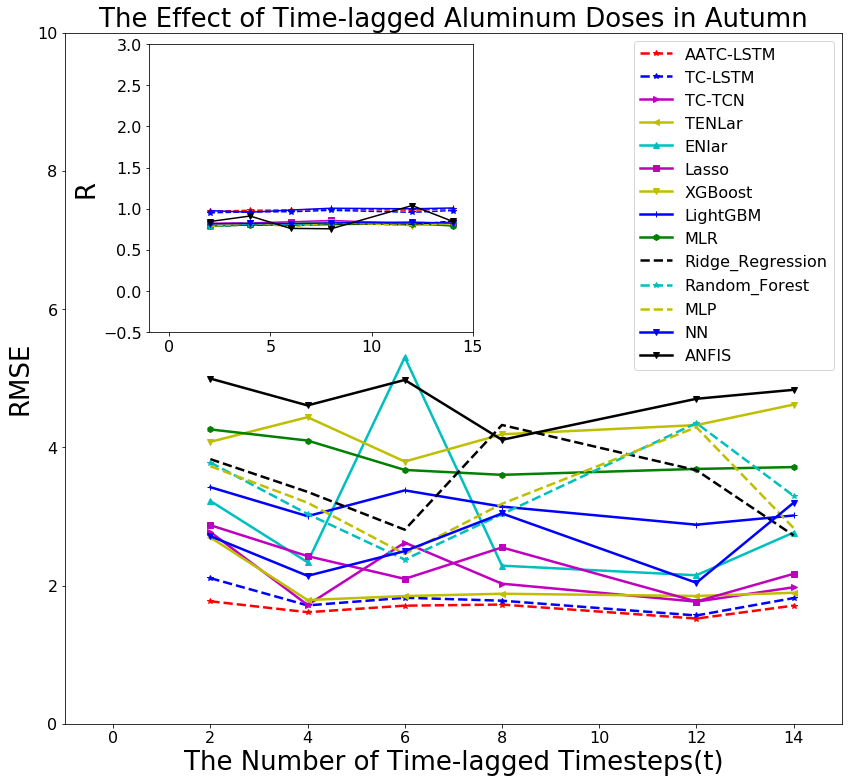

In [316]:
import matplotlib.pyplot as plt

styles = ['r*--','b*--', 'm>-', 'y<-', 'c^-', 'ms-', 'yv-', 'b+-', 'gh-','k--', 'c*--', 'y--', 'bv-', 'kv-']
methods_fmt = ['AATC-LSTM', 'TC-LSTM', 'TC-TCN', 'TENLar', 'ENlar', 'Lasso','XGBoost','LightGBM', 'MLR', 'Ridge_Regression', 'Random_Forest', 'MLP', 'NN', 'ANFIS',]
os.chdir(config.path)

result = np.load(osp.join('result', 'autumn.npy')).squeeze()


# remove results of LSTM
result = result.remove(result, 3, axis = 2 )
results = result.mean(0)

# result shape = [lag_time, methods]→RMSE + Correlation
rmse_results = results[:, :, 0]
correlation_results = results[:, :, 2]

fig = plt.figure(figsize = (9, 8))

ax1 = fig.add_axes([0.1, 0.1, 1.2, 1.2])
ax2 = fig.add_axes([0.23, 0.78, 0.5, 0.5])

# ploting Figure
for j,method in enumerate(methods_fmt):

    ax1.plot(np.array([2,4,6,8,12,14]),rmse_results[:, j], styles[j],linewidth = 2.5, label=method)
    ax2.plot(np.array([2,4,6,8,12,14]),correlation_results[:, j], styles[j], label=method)
    
    
ax1.set_title('The Effect of Time-lagged Aluminum Doses in Autumn', fontsize = 26)
ax1.tick_params(labelsize = 16)
ax1.set_xlim(-1,15)
ax1.set_ylim(0,10)
ax1.set_xlabel('The Number of Time-lagged Timesteps(t)',fontsize = 26)
ax1.set_ylabel('RMSE',fontsize = 26)

ax2.set_ylabel('R',fontsize = 26)
ax2.tick_params(labelsize = 16)
ax2.set_xlim(-1,15)
ax2.set_ylim(-0.5,3)

ax1.legend(loc = 'upper right', fontsize = 16)
os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('PAD_in_Autumn.pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)

plt.show()
plt.close()

## All Models on RMSEs and Rs of Aluminum Doses in Different Time-lagged Terms of Winter

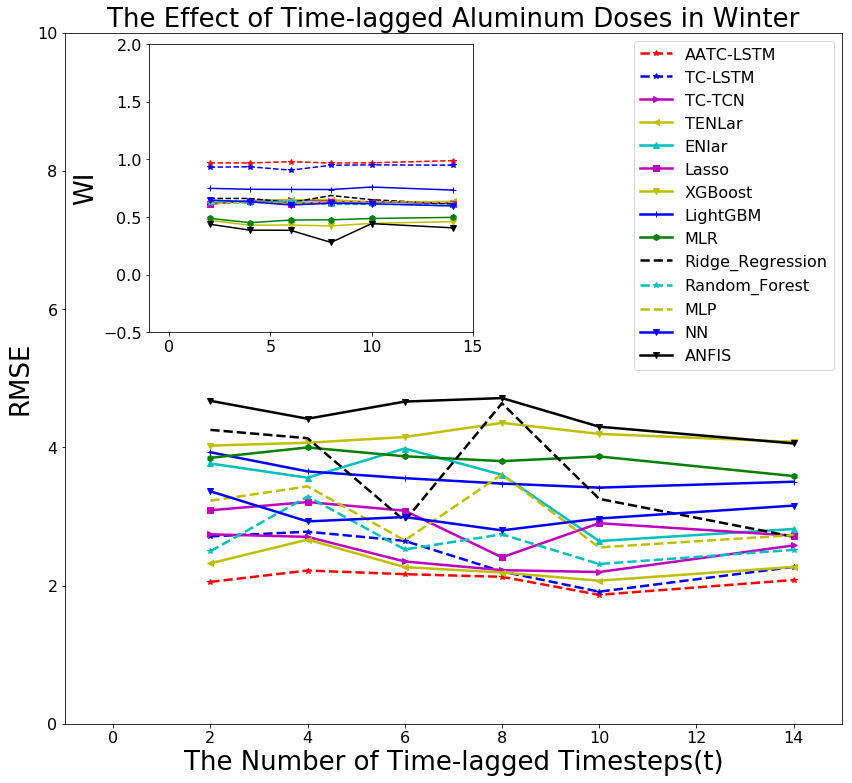

In [321]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,8))
styles = ['r*--','b*--', 'm>-', 'y<-', 'c^-', 'ms-', 'yv-', 'b+-', 'gh-','k--', 'c*--', 'y--', 'bv-', 'kv-']

methods_fmt = ['AATC-LSTM', 'TC-LSTM', 'TC-TCN', 'TENLar', 'ENlar', 'Lasso','XGBoost','LightGBM', 'MLR', 'Ridge_Regression', 'Random_Forest', 'MLP', 'NN', 'ANFIS',]

os.chdir(config.path)

result = np.load(osp.join('result', 'winter.npy')).squeeze()

# remove results of LSTM
result = result.remove(result, 3, axis = 2 )
results = result.mean(0)

# result shape = [lag_time, methods]→RMSE + Wi
rmse_results = results[:, :, 0]
wi_results = results[:, :, 3]


ax1 = fig.add_axes([0.1, 0.1, 1.2, 1.2])
ax2 = fig.add_axes([0.23, 0.78, 0.5, 0.5])

for j,method in enumerate(methods_fmt):


    ax1.plot(np.array([2,4,6,8,10,14]),rmse_results[:, j], styles[j], linewidth = 2.5, label=method)
    ax2.plot(np.array([2,4,6,8,10,14]),wi_results[:, j], styles[j], label=method)
    
    
ax1.set_title('The Effect of Time-lagged Aluminum Doses in Winter', fontsize = 26)
ax1.tick_params(labelsize = 16)
ax1.set_xlim(-1,15)
ax1.set_ylim(0,10)
ax1.set_xlabel('The Number of Time-lagged Timesteps(t)',fontsize = 26)
ax1.set_ylabel('RMSE',fontsize = 26)
ax2.set_ylabel('WI',fontsize = 26)
ax2.tick_params(labelsize = 16)
ax2.set_xlim(-1,15)
ax2.set_ylim(-0.5,2)

ax1.legend(loc = 'upper right', fontsize = 16)
os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('PAD_in_Winter.pdf' , bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.show()
plt.close()

## The Comparison Between AATC-LSTM and TC-SLTM in Training

## The Comparison Between AATC-LSTM and TC-SLTM in Testing

In [151]:
m.source.attr2source([('2015-01-01 00:00:00','2017-01-01 00:00:00')], 0, 0, 3, 'all')
a = m.source.all_x
b = m.source.all_y
print ("loading for testing completely...")

loading for testing completely...


## The changes of features in a period of time.  RW: raw water, SW: sedimentation water, C: carbon-processed water...

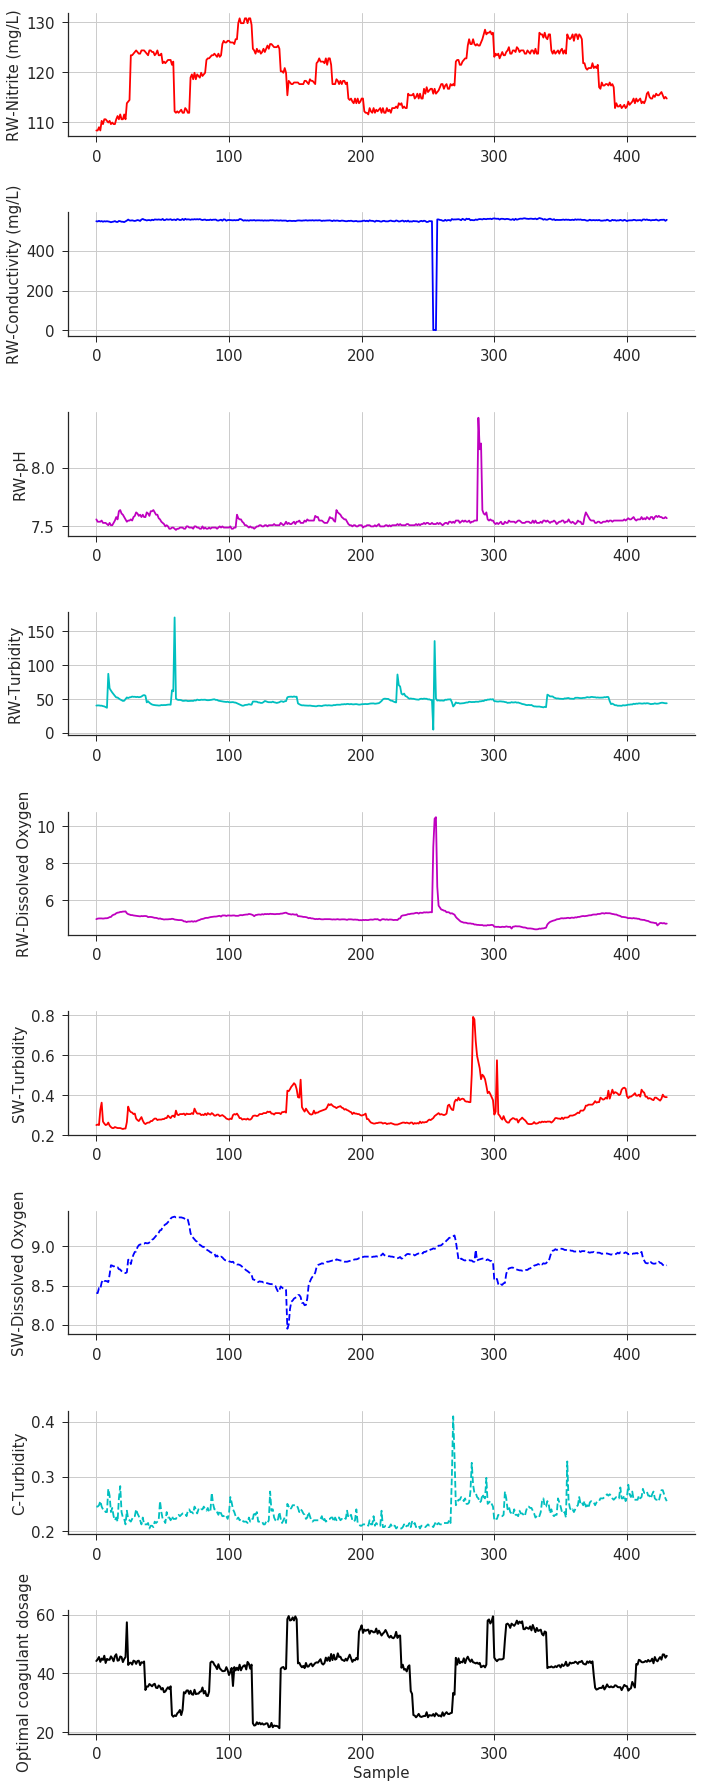

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.set_style("ticks")


fig = plt.figure(figsize=(10,25))

axes = plt.subplot(9,1,1)
plt.plot(a[:,0], 'r-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('RW-Nitrite (mg/L)',fontsize = 15)
plt.grid(True)

axes = plt.subplot(9,1,2)
plt.plot(a[:,1], 'b-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('RW-Conductivity (mg/L)',fontsize = 15)
plt.grid(True)

axes = plt.subplot(9,1,3)
plt.plot(a[:,2], 'm-', linewidth = 1.8)
plt.tick_params(labelsize=15)
plt.ylabel('RW-pH',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,4)
plt.plot(a[:,3], 'c-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('RW-Turbidity',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,5)
plt.plot(a[:,4], 'm-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('RW-Dissolved Oxygen',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,6)
plt.plot(a[:,5], 'r-', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('SW-Turbidity',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,7)
plt.plot(a[:,6], 'b--',linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('SW-Dissolved Oxygen',fontsize = 15)
plt.grid(True)


axes = plt.subplot(9,1,8)
plt.plot(a[:,7], 'c--', linewidth = 1.8)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('C-Turbidity',fontsize = 15)
plt.grid(True)

    
plt.subplot(9,1,9)
plt.plot(b, 'k-', linewidth = 2)
sns.despine()
plt.tick_params(labelsize=15)
plt.ylabel('Optimal coagulant dosage',fontsize = 15)
plt.xlabel('Sample',fontsize = 15)
plt.grid(True)

    
plt.tight_layout()
os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('Fetures_values_pic.pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.show() 
plt.close()

## Testing Predictive Dosage vs Observed Dosage

In [ ]:
# get all random result data
os.environ["CUDA_VISIBLE_DEVICES"]="0"
GT_test, GT_train, predicted_results_test, predicted_results_train = m.specify_experiments(config_final.methods, config_final.experiments)
print ("loading completely...")

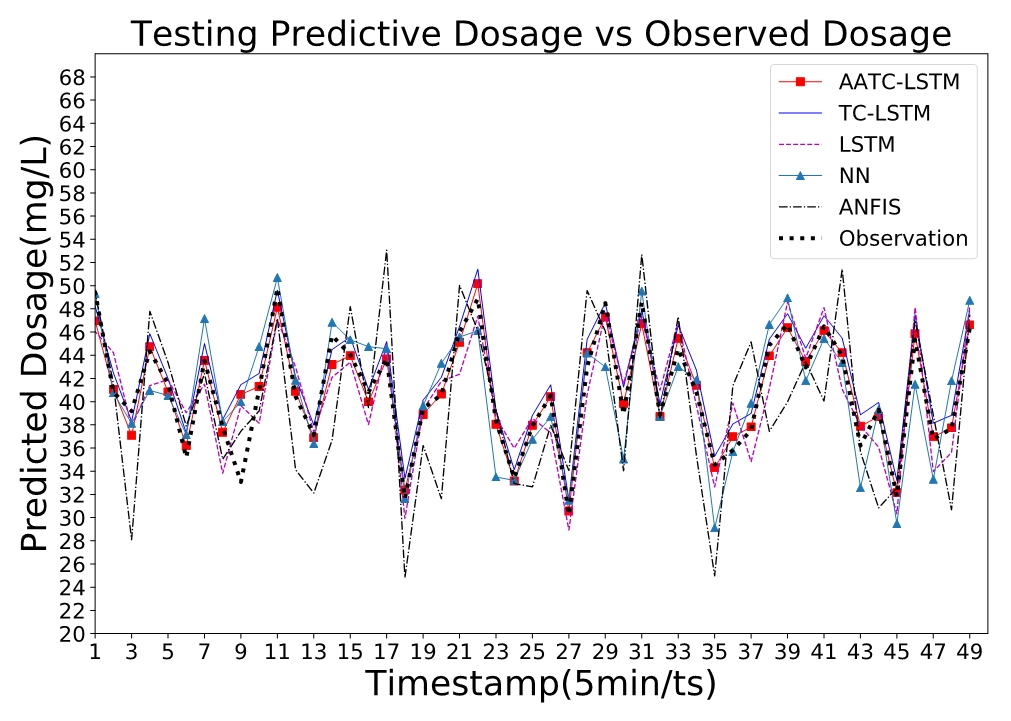

In [345]:
import matplotlib.pyplot as plt


# set sample number
sample_number = 50 
L = np.arange(sample_number)                                                                                                                                                                        
sample_id = np.random.randint(0,(1000 - sample_number + 1) )                                                                                           
fig = plt.figure(figsize=(9,6))
styles = ['r-','b-', 'k-', 'y-', 'c-', 'm-']
methods_fmt = ['AATC-LSTM', 'TC-LSTM','LSTM', 'NN', 'ANFIS']

os.chdir(config_final.path)
fig = plt.figure(figsize = (12, 8))

l_AATC, = plt.plot(L, predicted_results_test[0, sample_id:(sample_id+sample_number)], 'rs-', linewidth = 1)
l_TC, = plt.plot(L, (predicted_results_test[1, sample_id:(sample_id+sample_number)]), 'b-', linewidth = 1)
l_LSTM, = plt.plot(L, (predicted_results_test[3, sample_id:(sample_id+sample_number)]), 'm--', linewidth = 1)
l_NN, = plt.plot(L, (predicted_results_test[13, sample_id:(sample_id+sample_number)] ), '^-', linewidth = 1)
l_ANFIS, = plt.plot(L, (predicted_results_test[14, sample_id:(sample_id+sample_number)]), 'k-.', linewidth = 1)

l_GT, = plt.plot(L, GT_test[sample_id:(sample_id+sample_number)], 'k:', linewidth = 3)

lines_list = [l_AATC, l_TC, l_LSTM, l_NN, l_ANFIS, l_GT]
labels_list = ['AATC-LSTM','TC-LSTM', 'LSTM', 'NN', 'ANFIS', 'Observation']


plt.tick_params(labelsize = 16)
plt.xlim((1, sample_number))
plt.ylim((30,70))

plt.xlabel('Timestamp(5min/ts)', fontsize = 26)
plt.ylabel('Predicted Dosage(mg/L)', fontsize = 26)
plt.title('Testing Predictive Dosage vs Observed Dosage', fontsize = 26)
plt.xticks(np.arange(1, (sample_number + 1),2))
plt.yticks(np.arange(20, 70, 2))                                                                                           
plt.legend(handles = lines_list, labels = labels_list, loc = 'best', fontsize = 16)

os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('Test_PDvsOD.pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.show()
plt.close()



## Plot of Training Loss on AATC-LSTM vs TC-LSTM

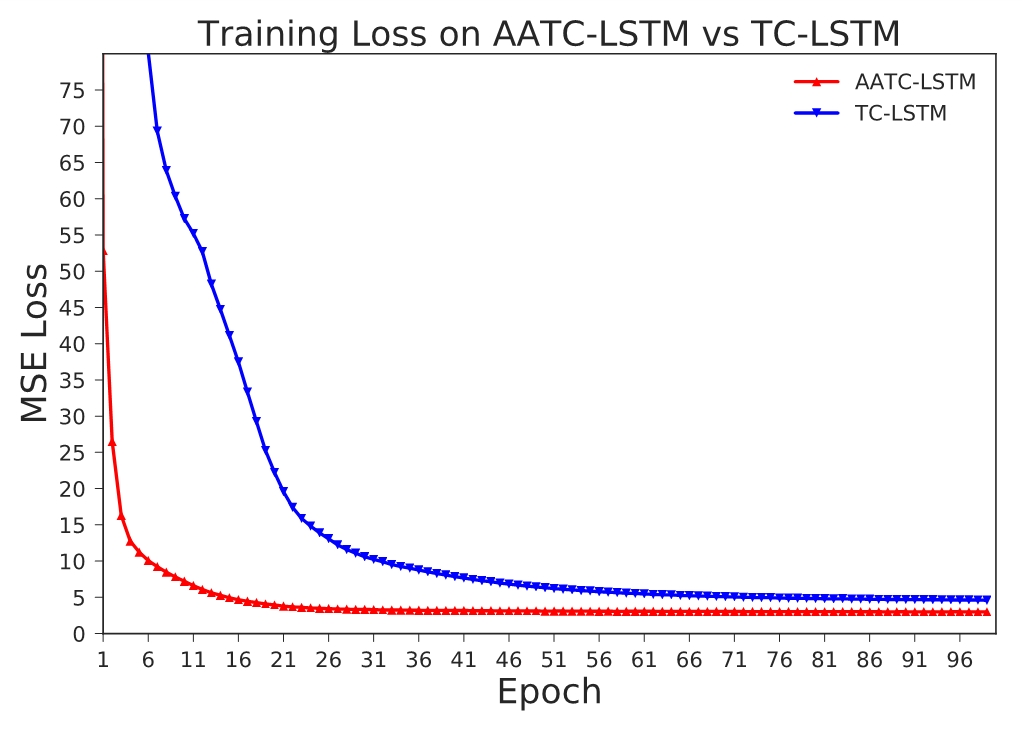

In [346]:
import matplotlib.pyplot as plt

epoch = 100
x = np.arange(0, epoch, 1)

y_aatc_train_averageLoss = loss_aatc_save[0:]
y_tc_train_averageLoss = loss_tc_save[0:]


fig = plt.figure(figsize=(12,8))

l1, = plt.plot(x, y_aatc_train_averageLoss, 'r^-', linewidth = 2.5)
l2, = plt.plot(x, y_tc_train_averageLoss, 'bv-', linewidth = 2.5)

plt.tick_params(labelsize = 16)
plt.xlim((1, epoch))
plt.ylim((0,80))


plt.xlabel('Epoch', fontsize = 26)
plt.ylabel('MSE Loss', fontsize = 26)
plt.title('Training Loss on AATC-LSTM vs TC-LSTM', fontsize = 26)


plt.xticks(np.arange(1,(epoch+1),5))
plt.yticks(np.arange(0,80,5))

plt.legend(handles = [l1,l2,], labels = ['AATC-LSTM', 'TC-LSTM'], loc = 'best', fontsize = 16)

# save
os.chdir('/home/yqliu/Yiqun_water/results')
fig.savefig('train_loss_aatclstm.pdf', bbox_inches='tight', pad_inches = 0.2, dpi = 300)
plt.show()
plt.close()



